# Model-assisted Labeling with YOLOv5

![base64 splash](https://github.com/PhilBrockman/ModelAssistedLabel/blob/master/modelassistedlabel%20splash.jpg?raw=true)

## Background

My exercise equipment doesn’t connect to a network. But I still want the "smart workout experience" when I'm using a "dumb" rowing machine.

If I maybe point my webcam at the equipment’s LCD output, I can make my computer interpret the digits. Perfect! I’ll just utilize object detection to determine the location and identity of digits on the machine’s readout. 

First question -- just a tiny one -- how do you do that?  

After wading through several guides, I found [Roboflow's YOLOv5 tutorial]( https://models.roboflow.com/object-detection/yolov5). They provide a hands-on and accessible experience in machine learning. But unfortunately, I couldn't progress immediately on my specific project. Instead, I had to build my own dataset.

As I labeled digits on image after image, tedium tore at me. I envisioned using the YOLOv5 model predictions as "pre-labels". I sleuth through [Ultralytic's](https://github.com/ultralytics/yolov5) original project, and I build wrappers around `detect.py` and `train.py`. I determine that my vision could be a reality.

This repository contains the tools that let me "pre-label" my images before sending them off for human inspection and correction. I also provide labeled and unlabeled images to demonstrate the tools.

* `Image Repo/`
 - `labeled/`
    + `Final Roboflow Export (841)/` 
      + 841 labeled image dataset
 - `unlabeled/`
    + `21-3-22 rowing (200) 7:50-12:50/`
      - 200 images with direct lighting from one light source
    + `21-3-22 rowing (200) 1:53-7:00/` 
      - 200 images with direct lighting from one light source and intermittent glare
    + `21-3-18 rowing 8-12/` 
      - 200 images with direct light and ambient lamps turned on




## Getting Started

> Tip: [Open In Colab](https://colab.research.google.com/github/PhilBrockman/ModelAssistedLabel/blob/master/index.ipynb) (and enable CPU)

In [ ]:
project_name = "seven segment digits - "

I back up the input files after writing them to disk just in case something breaks.

In [ ]:
backup_dir = "archive/Generation/zips"

Grab my code.

In [ ]:
!git clone https://github.com/PhilBrockman/ModelAssistedLabel.git
%cd "ModelAssistedLabel"

Cloning into 'ModelAssistedLabel'...
remote: Enumerating objects: 1023, done.
remote: Counting objects: 100% (1023/1023), done.
remote: Compressing objects: 100% (626/626), done.
remote: Total 5000 (delta 455), reused 907 (delta 359), pack-reused 3977
Receiving objects: 100% (5000/5000), 252.34 MiB | 32.54 MiB/s, done.
Resolving deltas: 100% (1478/1478), done.
Checking out files: 100% (2807/2807), done.
/content/ModelAssistedLabel


### Inputs

-  **labeled images**
    + All of the images and labels must be in a common folder (subfolders allowed).
    + Labels must be in [YOLOv5 format](https://github.com/AlexeyAB/Yolo_mark/issues/60#issuecomment-401854885).

    > Note: Image/label pairs are based on their base filename. For example `image.jpg/image.txt` would be paired as would `other_image5.jpg/other_image5.txt`.






In [ ]:
# these images have already been labeled
labeled_images = "Image Repo/labeled/Final Roboflow Export (841)"

  - **unlabeled images**

In [ ]:
# this run of 200 images needs to be annotated
unlabeled_images = "Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50"

### Output

* Folder that contains: 
    - `images/`
      + a copy of every image in **Unlabeled Data**
    - `labels/`
      + result of running object detection on each image
    - `class labels.txt` to preserve the identity of the classes
    - (if training detected) a results folder produced by Ultralytic's `train.py` on the **Labeled Data** 


Start by building the folder structure for the output.

In [ ]:
from ModelAssistedLabel.config import Defaults
import os

export_folder = Defaults._itername(project_name)

# make the export folder
os.mkdir(export_folder)

# make the images and labels subfolders
for resource_folder in ["images", "labels"]:
  os.mkdir(os.path.join(export_folder, resource_folder))

export_folder

'seven segment digits - 1'

### Configure Defaults

Several values are stored by the `Defaults` class. Make sure to `save()` any changes!

In [ ]:
d = Defaults()

#### Changing a `Default` Value

In [ ]:
print(" -- Defined Keys: --")
print("\n".join([x for x in d.__dict__.keys()]))

 -- Defined Keys: --
config_file
root
split_ratio
data_yaml
resource_map
trainer_template


Speciy the absolute path of the root directory.

In [ ]:
!pwd

/content/ModelAssistedLabel


In [ ]:
d.root = "/content/ModelAssistedLabel/"

Save changes and enter root directory

In [ ]:
d.save()
d.to_root()

moving to /content/ModelAssistedLabel/


#### Cloning YOLOv5

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo

%cd yolov5
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 5595 (delta 7), reused 10 (delta 1), pack-reused 5569
Receiving objects: 100% (5595/5595), 8.46 MiB | 33.32 MiB/s, done.
Resolving deltas: 100% (3815/3815), done.
/content/ModelAssistedLabel/yolov5
     |████████████████████████████████| 645kB 8.0MB/s 
/content/ModelAssistedLabel


#### Define Class Map


(`data_yaml` value was pulled from Roboflow tutorial)

I have `nc = 10` classes and their `names` are all string types. 


In [ ]:
d.data_yaml = """train: ../train/images
val: ../valid/images

nc: 10
names: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']"""

d.save()

Make sure that the class names are accessible:

In [ ]:
d.get_class_names()

['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

Store the class labels with index 0 on line 1, index 1 on line 2, and so on.

In [ ]:
with open(os.path.join(export_folder, "label_map.txt"), "w") as label_map:
  label_map.writelines("\n".join(d.get_class_names()))

## Generating Weights


Check to see the plan for this notebook's lifespan.

In [ ]:
if torch.cuda.is_available():
  #GPU enabled and ready to train some models
  print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) ))
else:
    #no GPU access
    raise Exception("Enable GPU to make predictions or train a model.")

Setup complete. Using torch 1.8.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


### Preparing Filesystem

The `Generation` class helps convert an unordered folder of images and labels into a format compatible with YOLOv5. By default, the train/valid/test split is set to 70%/20%/10%.

In [ ]:
from ModelAssistedLabel.fileManagement import Generation

g = Generation(repo=labeled_images, 
               out_dir=backup_dir,
               verbose=True)

g.set_split()
g.get_split()

[{'train': 589}, {'valid': 169}, {'test': 83}]

Backups are built into this system. As an intermediate step, the split must be written to disk in `g.out_dir`.


In [ ]:
zipped = g.write_split_to_disk(descriptor=export_folder)


dirs ['./train', './valid', './test']
yaml archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41/data.yaml
subdir train
	outdir archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41
subdir valid
	outdir archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41
subdir test
	outdir archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41
os.listdir ['test', 'data.yaml', 'valid', 'train']


Next, the images need to be written in a way so that the Ultralytics repository can understand their content. The `AutoWeights` class both organizes data and create weights.

In [ ]:
from ModelAssistedLabel.train import AutoWeights
#configure a basic AutoWeights class instance
aw = AutoWeights(name=export_folder, out_dir=backup_dir)

# create train/valid/test split from a bag of labeled images (recusively seek out images/labels)
aw.initialize_images_from_zip(zipped)

mv 'unzipped/archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41/test' .
mv 'unzipped/archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41/data.yaml' .
mv 'unzipped/archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41/valid' .
mv 'unzipped/archive/Generation/zips/Final Roboflow Export (841)seven segment digits - 1 21-03-29 17-47-41/train' .


Inspect the sizes of the train/valid/test groups.

In [ ]:
aw.traverse_resources()

test/labels
	 > 83 files
test/images
	 > 83 files
File:  data.yaml
valid/labels
	 > 169 files
valid/images
	 > 169 files
train/labels
	 > 589 files
train/images
	 > 589 files


### Running `train.py` (GPU)

With the images written to disk, we can run the Ultralytics training algorithm. I loved watching the progress fly by in real time on the original `train.py`. Fortunately, the Ultralytics folk write the results file to disk so the model's training data is still accessible!

> Note: this output has already been calculated and stored in `pre-trained/results` for convenience.

In [ ]:
%%time

"Uncomment this cell to skip training."
# results_folder="pre-trained/results" 

try:
  #using pretrained results
  results_folder
except NameError:
  #let the model train and find something else to do for a few hours
  aw.generate_weights(epochs=1, yaml_data=Defaults().trainer_template)

  # access the folder of results from the AutoWeights instance
  results_folder = aw.last_results_path

print("Results: ", results_folder)

CPU times: user 1min 3s, sys: 10.8 s, total: 1min 14s
Wall time: 4h 57min 26s


'yolov5/runs/train/seven segment digits - 1/'

The results folder is stored as an attribute as well, and it has a lot of charts and images stored therein.

In [ ]:
import os
aw.last_results_path, len(os.listdir(aw.last_results_path))

('yolov5/runs/train/seven segment digits - 1/', 22)

However, the weights are stored in a subfolder called (aptly) "weights".

In [ ]:
os.listdir(aw.last_results_path + "/weights")

['last.pt', 'best.pt']

## Machine-assisted Labeling

### Labeling a New Set of Images (GPU)

The `Viewer` class needs weights and class labels to operate.

In [ ]:
from ModelAssistedLabel.detect import Viewer

# access the folder of results from the AutoWeights instance
results_folder = aw.last_results_path

# I'm choosing to use the best weight.
weight_path = results_folder + "/weights/best.pt"

# Viewer needs a set of weights and an array of labels for the detected object types
v = Viewer(weight_path, Defaults().get_class_names())

Fusing layers... 


Let's us look through the computer's eyes at the images.

With the existing dataset, the model performs best under direct lighting.

In [ ]:
%matplotlib inline 
import random, glob

images = glob.glob(f"{unlabeled_images}/*.jpg")

for image in random.sample(images,5):
  print(image)
  v.plot_for(image)

Output hidden; open in https://colab.research.google.com to view.

Make predictions for all images.

In [ ]:
results = []

for image in images:
  results.append(v.predict_for(image))

#### Predictions Spot Check

In all 600 unlabeled images, the screen has 4 digits.

So lets take a look at the numbers of predictions being made:

Text(0.5, 1.0, 'Number of predictions per image')

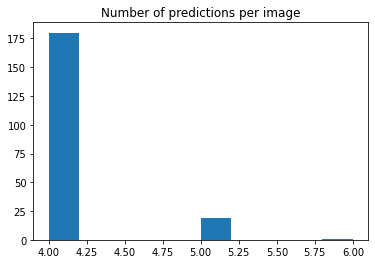

In [ ]:
import pandas as pd

ax = pd.Series([len(x["predictions"]) for x in results]).hist()
ax.grid(False)
ax.set_title(label = "Number of predictions per image")

At this stage in development, the YOLOv5 model could still be prone to false positives. However, I interpret the above data to suggest that there are overlapping bounding boxes that need to be resolved.

There are a couple of possible entry points to a programitic solution. The `Detector` class (build on top of Ultralytic's `detect.py`) has an `iou_threshold` attribute (read about [Intersection Over Union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)) that can be fiddled with. Further, in resolving overlapping bounding boxes post-hoc, I would turn to the confidence attribute stored in the `results` array.

### Exporting Annotated Images

Ensure that image/label pairs have a common root filename and collect relevant files in a single folder.

In [ ]:
import random, PIL, shutil
salt = lambda: str(random.random())[2:] 

for result in results:
  # In case the salt somehow fails to be unique, forcibly generate a unique filename
  shared_root = Defaults._itername(f"{project_name}-{salt()}")

  #save the image to the outfolder
  image = PIL.Image.open(result["image path"])
  image.save(os.path.join(export_folder, "images", f"{shared_root}.jpg"))

  #save the predictions to the outfolder
  predictions = result["predictions"]
  with open(os.path.join(export_folder, "labels", f"{shared_root}.txt"), "w") as prediction_file:
    prediction_file.writelines("\n".join([x["yolov5 format"] for x in predictions]))

Lastly, if results need to get saved, make sure they get saved.

In [ ]:
moved = False #set a flag

try: 
  if aw and 'last_results_path' in aw.__dict__ and os.path.exists(aw.last_results_path):
    # `aw` exists and it has been executed 
    print(f"Moving yolov5 results: {aw.last_results_path}")
    shutil.move(aw.last_results_path, export_folder)

    #flip the flag
    moved = True
except NameError:
  #no results attempted
  pass

if not(moved):
  # either the AutoWeigts didn't pan out or it wasn't used
  print("No weights to save")

Moving yolov5 results: yolov5/runs/train/seven segment digits - 1/


In [ ]:
export_folder

'seven segment digits - 1'

I labeled dozens upon dozens and dozens of images with Roboflow and would recommend their free annotation service! However, to be transparent, I developed [an annotator](https://github.com/PhilBrockman/autobbox) in React that better suited my physical needs.

## Building up an Image Set

Keep in mind the `Generation` class recursively finds all images and lables. So as long as the newly annotated images and the original Image Set are in the same folder, `Generation`'s constructor function will find them.

And every time `Generation` calls a `split_to_disk` that split is archived in `backup_dir`

## Wrap Up

I have uncovered a camera and lighting positioning that allows for my model to read the LCD at with high fidelty. I'm using object detection as a form of OCR and it's working!

I see three main areas for development with this project. The first would be bolstering the dataset (and staying in the machine learning space). The second would be logic interpreting parsed data (building the "smart" software).

The third area of development is refactoring. I made a decision early on to hard to hardcode the path to training and validation images. It's worth revisiting the way `Defaults.data_yaml` is constructed.



### Note on the Image Set

This dataset of 841 images is a mishmash. There's images from a different rowing machine and also from  [this](https://github.com/SachaIZADI/Seven-Segment-OCR) repo. Some scenes are illuminated with sunlight. Others have been cropped to include only the LCD. Digits like 7, 8, and 9 are underrepresented.

### Recording from Laptop

This is my setup for how I'm currently fixing the position my black-shelled laptop while recording: [pic1](https://raw.githubusercontent.com/PhilBrockman/ModelAssistedLabel/master/DIY-laptop-mount.jpg), [pic2](https://raw.githubusercontent.com/PhilBrockman/ModelAssistedLabel/master/DIY-computer-capture.jpg), [pic3](https://github.com/PhilBrockman/ModelAssistedLabel/blob/master/DIY-capture.jpeg?raw=true).

I use the `_capture.ipynb` notebook to capture images on a bit of a delay to prevent repeat images from cluttering the dataset. For me, it was much easier to get recording working from a local notebook than from a Colab notebook but YMMV.



### About Me

I am finishing my fourth year as a public school teacher in Kentucky. This summer, I am moving to the Bay Area to pursue a career in tech. When I’m not coding, I enjoy playing violin! Reach me at phil.brockman@gmail.com.

